In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from collections import Counter
from tqdm import tqdm

In [477]:
df_confs = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Naef_Training_incl_num_confs_and_tabs.csv')
df_confs['smiles'] = df_confs['molblock'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromMolBlock(x)))
df_confs_organic = df_confs[~df_confs['smiles'].str.contains('B|Si|As|Se')]
print(len(df_confs)-len(df_confs_organic), 'inorganic compounds (containing B, Si, As, or Se) removed')
molregno_to_molblock = dict(zip(df_confs['molregno'], df_confs['molblock']))

229 inorganic compounds (containing B, Si, As, or Se) removed


In [312]:
atom_nums = []
for molb in tqdm(df_confs_organic['molblock']):
    mol = Chem.MolFromMolBlock(molb)
    for atom in mol.GetAtoms():
        atom_num = atom.GetSymbol()
        atom_nums.append(atom_num)
print(Counter(atom_nums))

 36%|███▌      | 1009/2789 [00:00<00:00, 10080.25it/s]

100%|██████████| 2789/2789 [00:00<00:00, 9505.14it/s] 

Counter({'C': 24758, 'O': 3165, 'Cl': 2213, 'F': 1575, 'N': 1282, 'S': 343, 'P': 103, 'I': 37, 'H': 2})


Text(0.5, 0, 'log_ntabs')

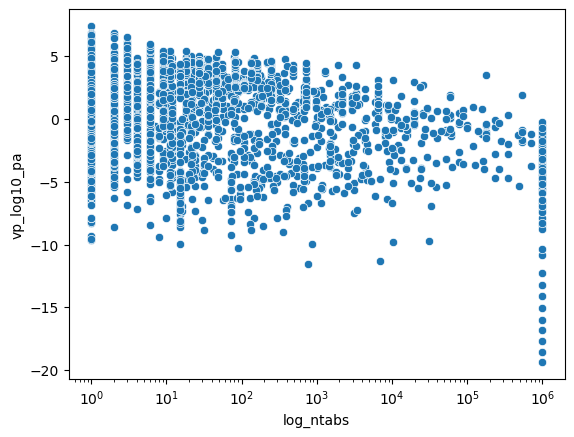

In [313]:
#plot log ntabs against vp_log10_pa
plt.figure()
sns.scatterplot(x='ntabs', y='vp_log10_pa', data=df_confs_organic)
plt.xscale('log')
plt.ylabel('vp_log10_pa')
plt.xlabel('log_ntabs')

In [437]:
#load data again from pickles
import pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_PhysChem.pkl', 'rb') as f:
    data_xgboost_physchem = pickle.load(f)
pred_list_xgboost_physchem = data_xgboost_physchem['pred_list']
ys_list_xgboost_physchem = data_xgboost_physchem['ys_list']
molregnos_xgboost_physchem = data_xgboost_physchem['molregnos']
#make df
pred_list_xgboost_physchem_flat = [item for sublist in pred_list_xgboost_physchem for item in sublist]
ys_list_xgboost_physchem_flat = [item for sublist in ys_list_xgboost_physchem for item in sublist]
molregnos_xgboost_physchem_flat = [item for sublist in molregnos_xgboost_physchem for item in sublist]
df_results_xgboost_physchem = pd.DataFrame({'Pred_Physchem': pred_list_xgboost_physchem_flat, 'vp_log10_pa': ys_list_xgboost_physchem_flat, 'molregno': molregnos_xgboost_physchem_flat})
molregno_to_ntabs = dict(zip(df_confs_organic['molregno'], df_confs_organic['ntabs']))
#keep only molregnos that are also in df_confs_organic
df_results_xgboost_physchem = df_results_xgboost_physchem[df_results_xgboost_physchem['molregno'].isin(df_confs_organic['molregno'])]
df_results_xgboost_physchem['ntabs'] = df_results_xgboost_physchem['molregno'].apply(lambda x: molregno_to_ntabs[x])
df_results_xgboost_physchem['log10ntabs'] = np.log10(df_results_xgboost_physchem['ntabs'])
df_results_xgboost_physchem['AE'] = abs(df_results_xgboost_physchem['Pred_Physchem'] - df_results_xgboost_physchem['vp_log10_pa'])

#average over molregno
df_results_xgboost_physchem_avg = df_results_xgboost_physchem.groupby('molregno').mean()

In [438]:
df_results_xgboost_physchem_high_errror = df_results_xgboost_physchem_avg[df_results_xgboost_physchem_avg['AE'] > 2]
#count % of rigid molecules (ntabs < 50) and flexible (ntabs = 1000000) for both and print out
rigid_high_error = df_results_xgboost_physchem_high_errror[df_results_xgboost_physchem_high_errror['ntabs'] < 50]
rigid_all = df_results_xgboost_physchem_avg[df_results_xgboost_physchem_avg['ntabs'] < 50]

flexible_high_error = df_results_xgboost_physchem_high_errror[df_results_xgboost_physchem_high_errror['ntabs'] == 1000000]
flexible_all = df_results_xgboost_physchem_avg[df_results_xgboost_physchem_avg['ntabs'] == 1000000]

print('Rigid molecules with high error:', len(rigid_high_error)/len(df_results_xgboost_physchem_high_errror)*100)
print('Rigid molecules with overall:', len(rigid_all)/len(df_results_xgboost_physchem_avg)*100)

print('Flexible molecules with high error:', len(flexible_high_error)/len(df_results_xgboost_physchem_high_errror)*100)
print('Flexible molecules with overall:', len(flexible_all)/len(df_results_xgboost_physchem_avg)*100)

#print number of moles for both
print('Number of datapoints with high error:', len(df_results_xgboost_physchem_high_errror))
print('Number of datapoints overall:', len(df_results_xgboost_physchem_avg))

# print('Number of molecules with high error:', len(df_results_xgboost_physchem_high_errror



Rigid molecules with high error: 64.55696202531645
Rigid molecules with overall: 68.34532374100719
Flexible molecules with high error: 3.79746835443038
Flexible molecules with overall: 3.6870503597122304
Number of datapoints with high error: 79
Number of datapoints overall: 2224


In [ ]:
df_results_xgboost_physchem['AE'] = abs(df_results_xgboost_physchem['Pred_Physchem'] - df_results_xgboost_physchem['vp_log10_pa'])
df_results_xgboost_physchem_high_errror = df_results_xgboost_physchem[df_results_xgboost_physchem['AE'] > 2]
#count % of rigid molecules (ntabs < 50) and flexible (ntabs = 1000000) for both and print out
rigid_high_error = df_results_xgboost_physchem_high_errror[df_results_xgboost_physchem_high_errror['ntabs'] < 50]
rigid_all = df_results_xgboost_physchem[df_results_xgboost_physchem['ntabs'] < 50]

flexible_high_error = df_results_xgboost_physchem_high_errror[df_results_xgboost_physchem_high_errror['ntabs'] == 1000000]
flexible_all = df_results_xgboost_physchem[df_results_xgboost_physchem['ntabs'] == 1000000]

print('Rigid molecules with high error:', len(rigid_high_error)/len(df_results_xgboost_physchem_high_errror)*100)
print('Rigid molecules with overall:', len(rigid_all)/len(df_results_xgboost_physchem)*100)

print('Flexible molecules with high error:', len(flexible_high_error)/len(df_results_xgboost_physchem_high_errror)*100)
print('Flexible molecules with overall:', len(flexible_all)/len(df_results_xgboost_physchem)*100)

#print number of moles for both
print('Number of datapoints with high error:', len(df_results_xgboost_physchem_high_errror))
print('Number of datapoints overall:', len(df_results_xgboost_physchem))

print('Number of molecules with high error:', len(df_results_xgboost_physchem_high_errror['molregno'].unique()))
print('Number of molecules overall:', len(df_results_xgboost_physchem['molregno'].unique()))


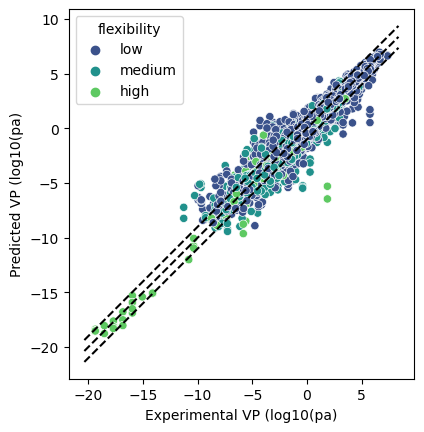

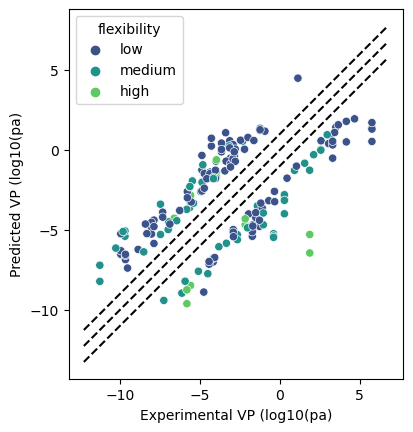

In [415]:
df_results_xgboost_physchem['flexibility'] = pd.cut(df_results_xgboost_physchem['ntabs'], bins=[0, 50, 99999, 100000000], labels=['low', 'medium', 'high'])
#plot pred against vp_log10_pa, color by ntabs
plt.figure()
sns.scatterplot(x='vp_log10_pa', y='Pred_Physchem', data=df_results_xgboost_physchem, hue='flexibility', palette='viridis')
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem['vp_log10_pa'].min(), df_results_xgboost_physchem['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem['vp_log10_pa'].max(), df_results_xgboost_physchem['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('Predicted VP (log10(pa)')
plt.xlabel('Experimental VP (log10(pa)')
#make square    
plt.gca().set_aspect('equal', adjustable='box')
df_results_xgboost_physchem_high_errror = df_results_xgboost_physchem[df_results_xgboost_physchem['AE'] > 2]

#same plot, but only errors > 2
plt.figure()
sns.scatterplot(x='vp_log10_pa', y='Pred_Physchem', data=df_results_xgboost_physchem_high_errror, hue='flexibility', palette='viridis')
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem_high_errror['vp_log10_pa'].min(), df_results_xgboost_physchem_high_errror['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem_high_errror['vp_log10_pa'].max(), df_results_xgboost_physchem_high_errror['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('Predicted VP (log10(pa)')
plt.xlabel('Experimental VP (log10(pa)')
#make square
plt.gca().set_aspect('equal', adjustable='box')


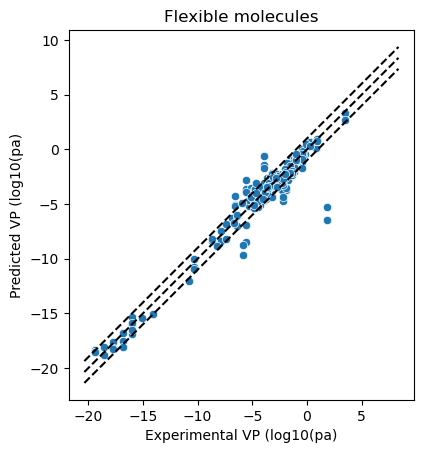

In [465]:
plt.figure()
sns.scatterplot(x='vp_log10_pa', y='Pred_Physchem', data=df_results_xgboost_physchem[df_results_xgboost_physchem['flexibility']== 'high'])
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem['vp_log10_pa'].min(), df_results_xgboost_physchem['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem['vp_log10_pa'].max(), df_results_xgboost_physchem['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('Predicted VP (log10(pa)')
plt.xlabel('Experimental VP (log10(pa)')
plt.title('Flexible molecules')
#make square
plt.gca().set_aspect('equal', adjustable='box')


In [467]:
df_results_xgboost_physchem[df_results_xgboost_physchem['flexibility']== 'high']


,Pred_Physchem,vp_log10_pa,molregno,ntabs,log10ntabs,AE,model,flexibility
1,-1.214461,-0.959000,15772,137781,5.139189,0.255461,PhysChem,high
16,-5.152018,-5.330998,16489,497664,5.696936,0.178980,PhysChem,high
39,-2.382587,-2.127798,3739,1000000,6.000000,0.254788,PhysChem,high
49,-1.235338,-1.185198,3052,708588,5.850394,0.050140,PhysChem,high
73,-3.732011,-3.592898,3144,1000000,6.000000,0.139114,PhysChem,high
...,...,...,...,...,...,...,...,...
5421,-2.634492,-2.850198,3071,1000000,6.000000,0.215706,PhysChem,high
5432,0.734089,0.929402,771,118098,5.072243,0.195313,PhysChem,high
5464,-5.994738,-6.434000,15845,1000000,6.000000,0.439262,PhysChem,high
5466,-18.531052,-19.360000,15810,1000000,6.000000,0.828948,PhysChem,high


In [489]:
df_results_xgboost_physchem_copy = df_results_xgboost_physchem.drop(columns=['model', 'flexibility'])

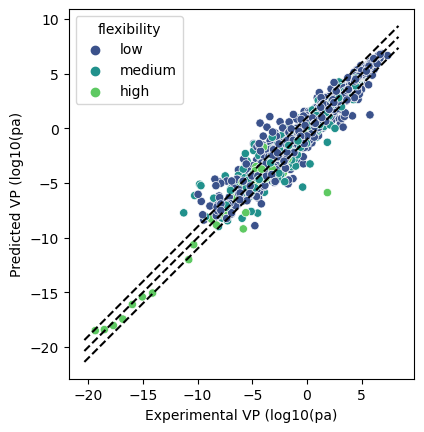

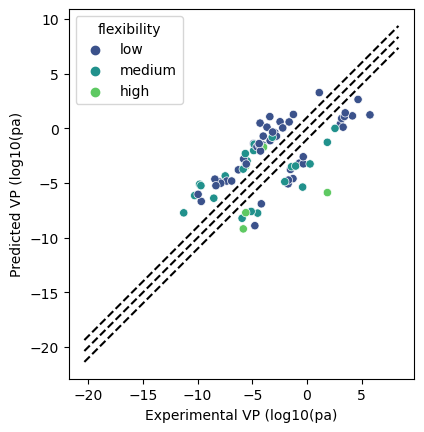

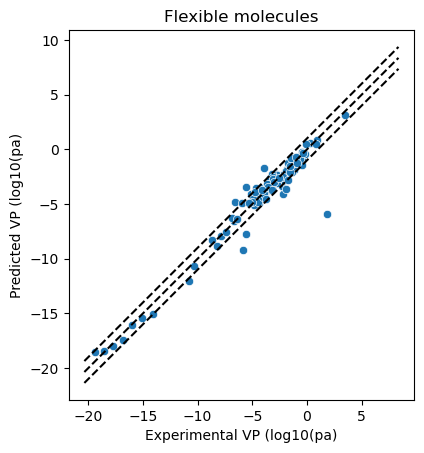

In [490]:
# df_results_xgboost_physchem_copy = df_results_xgboost_physchem.drop(columns=['ntabs_cat', 'flexibility'])
#average
df_results_xgboost_physchem_copy = df_results_xgboost_physchem_copy.groupby('molregno').mean()
df_results_xgboost_physchem_copy['ntabs'] = df_results_xgboost_physchem_copy.index.map(molregno_to_ntabs)
#plot pred against vp_log10_pa, color by ntabs
df_results_xgboost_physchem_copy['flexibility'] = pd.cut(df_results_xgboost_physchem_copy['ntabs'], bins=[0, 50, 99999, 100000000], labels=['low', 'medium', 'high'])
#plot pred against vp_log10_pa, color by ntabs
plt.figure()
sns.scatterplot(x='vp_log10_pa', y='Pred_Physchem', data=df_results_xgboost_physchem_copy, hue='flexibility', palette='viridis')
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem_copy['vp_log10_pa'].min(), df_results_xgboost_physchem_copy['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem_copy['vp_log10_pa'].max(), df_results_xgboost_physchem_copy['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('Predicted VP (log10(pa)')
plt.xlabel('Experimental VP (log10(pa)')
#make square    
plt.gca().set_aspect('equal', adjustable='box')
df_results_xgboost_physchem_high_errror = df_results_xgboost_physchem_copy[df_results_xgboost_physchem_copy['AE'] > 2]

#same plot, but only errors > 2
plt.figure()
sns.scatterplot(x='vp_log10_pa', y='Pred_Physchem', data=df_results_xgboost_physchem_high_errror, hue='flexibility', palette='viridis')
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem_copy['vp_log10_pa'].min(), df_results_xgboost_physchem_copy['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem_copy['vp_log10_pa'].max(), df_results_xgboost_physchem_copy['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('Predicted VP (log10(pa)')
plt.xlabel('Experimental VP (log10(pa)')
#make square
plt.gca().set_aspect('equal', adjustable='box')
plt.figure()
sns.scatterplot(x='vp_log10_pa', y='Pred_Physchem', data=df_results_xgboost_physchem_copy[df_results_xgboost_physchem_copy['flexibility']== 'high'])
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem_copy['vp_log10_pa'].min(), df_results_xgboost_physchem_copy['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem_copy['vp_log10_pa'].max(), df_results_xgboost_physchem_copy['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('Predicted VP (log10(pa)')
plt.xlabel('Experimental VP (log10(pa)')
plt.title('Flexible molecules')
#make square
plt.gca().set_aspect('equal', adjustable='box')



In [493]:
#round AE
flex_db['AE_rounded'] = flex_db['AE'].round(2)
flex_db

/tmp/ipykernel_2218393/1527444356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flex_db['AE_rounded'] = flex_db['AE'].round(2)


,Pred_Physchem,vp_log10_pa,ntabs,log10ntabs,AE,flexibility,molblcok,ROMol,AE_rounded
molregno,,,,,,,,,
30,-1.790840,-1.222000,1000000,6.000000,0.568840,high,[H]N(C([H])([H])C([H])([H])C([H])([H])C([H])([...,<rdkit.Chem.rdchem.Mol object at 0x7f8f68f404a0>,0.57
41,-0.985161,-0.453498,1000000,6.000000,0.531664,high,[H]C([H])=C([H])C([H])([H])C([H])([H])C([H])([...,<rdkit.Chem.rdchem.Mol object at 0x7f8f68f40580>,0.53
106,-0.716117,-1.034398,177147,5.248334,0.349587,high,[H]SC([H])([H])C([H])([H])C([H])([H])C([H])([H...,<rdkit.Chem.rdchem.Mol object at 0x7f8f68f40430>,0.35
125,-1.795613,-1.833698,531441,5.725455,0.270844,high,[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...,<rdkit.Chem.rdchem.Mol object at 0x7f8f68f403c0>,0.27
132,-4.439442,-4.875098,1000000,6.000000,0.561803,high,[H]c1c([H])c([H])c(C(=O)OC([H])([H])C([H])([H]...,<rdkit.Chem.rdchem.Mol object at 0x7f8f68f40350>,0.56
...,...,...,...,...,...,...,...,...,...
16746,-4.520367,-3.728998,1000000,6.000000,0.791369,high,[H]OC(=O)C([H])([H])C([H])([H])C([H])([H])C([H...,<rdkit.Chem.rdchem.Mol object at 0x7f8f68f3d540>,0.79
16940,-0.313806,-0.339798,266085,5.425020,0.178044,high,[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,<rdkit.Chem.rdchem.Mol object at 0x7f8f68f3d3f0>,0.18
16946,-8.845616,-8.270898,1000000,6.000000,0.574718,high,[H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...,<rdkit.Chem.rdchem.Mol object at 0x7f8f68f3d380>,0.57


113


/tmp/ipykernel_2218393/2992180865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flex_db['molblcok'] = flex_db.index.map(molregno_to_molblock)
/tmp/ipykernel_2218393/2992180865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flex_db['ROMol'] = flex_db['molblcok'].apply(lambda x: Chem.MolFromMolBlock(x))
/tmp/ipykernel_2218393/2992180865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

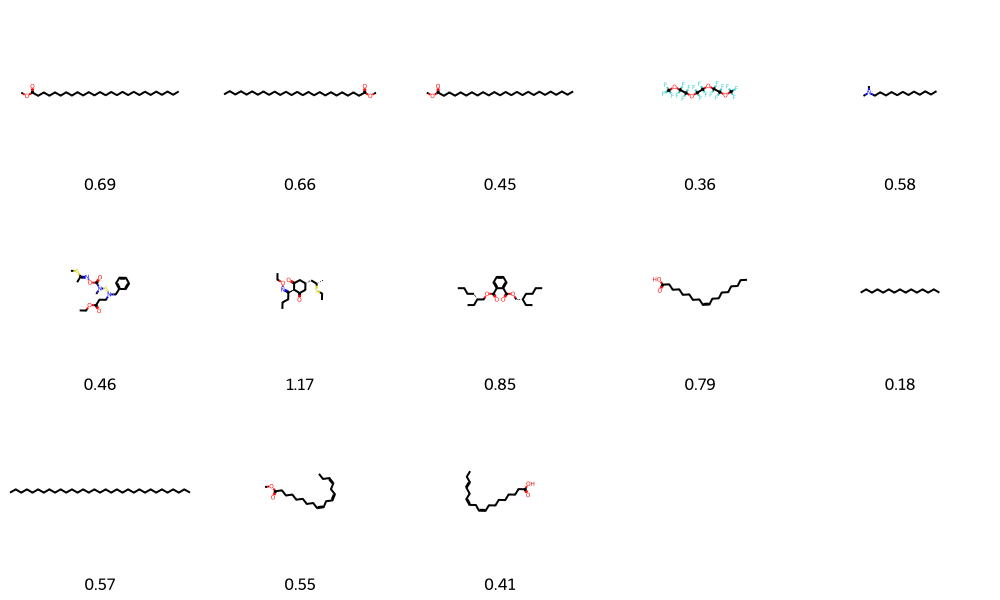

In [508]:
flex_db = df_results_xgboost_physchem_copy[df_results_xgboost_physchem_copy['flexibility']== 'high']
flex_db['molblcok'] = flex_db.index.map(molregno_to_molblock)
flex_db['ROMol'] = flex_db['molblcok'].apply(lambda x: Chem.MolFromMolBlock(x))
flex_db['ROMol'] = flex_db['ROMol'].apply(lambda x: Chem.MolFromSmiles(Chem.MolToSmiles(x)))
from rdkit.Chem import PandasTools
# PandasTools.AddMoleculeColumnToFrame(flex_db, 'ROMol')
flex_db['AE_rounded'] = flex_db['AE'].round(2)
print(len(flex_db))
#get first 50
flex_db_tmp = flex_db[100:]
img = PandasTools.FrameToGridImage(flex_db_tmp, molsPerRow=5, legendsCol='AE_rounded', subImgSize=(200, 200))
img

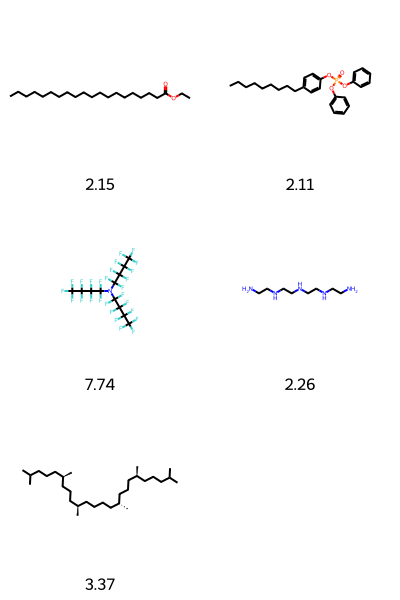

In [510]:
flex_db_high_error = flex_db[flex_db['AE'] > 2]
img = PandasTools.FrameToGridImage(flex_db_high_error, molsPerRow=2, legendsCol='AE_rounded', subImgSize=(200, 200))
img

/tmp/ipykernel_2218393/4021201871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rigid_db['molblcok'] = rigid_db.index.map(molregno_to_molblock)
/tmp/ipykernel_2218393/4021201871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rigid_db['ROMol'] = rigid_db['molblcok'].apply(lambda x: Chem.MolFromMolBlock(x))
/tmp/ipykernel_2218393/4021201871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

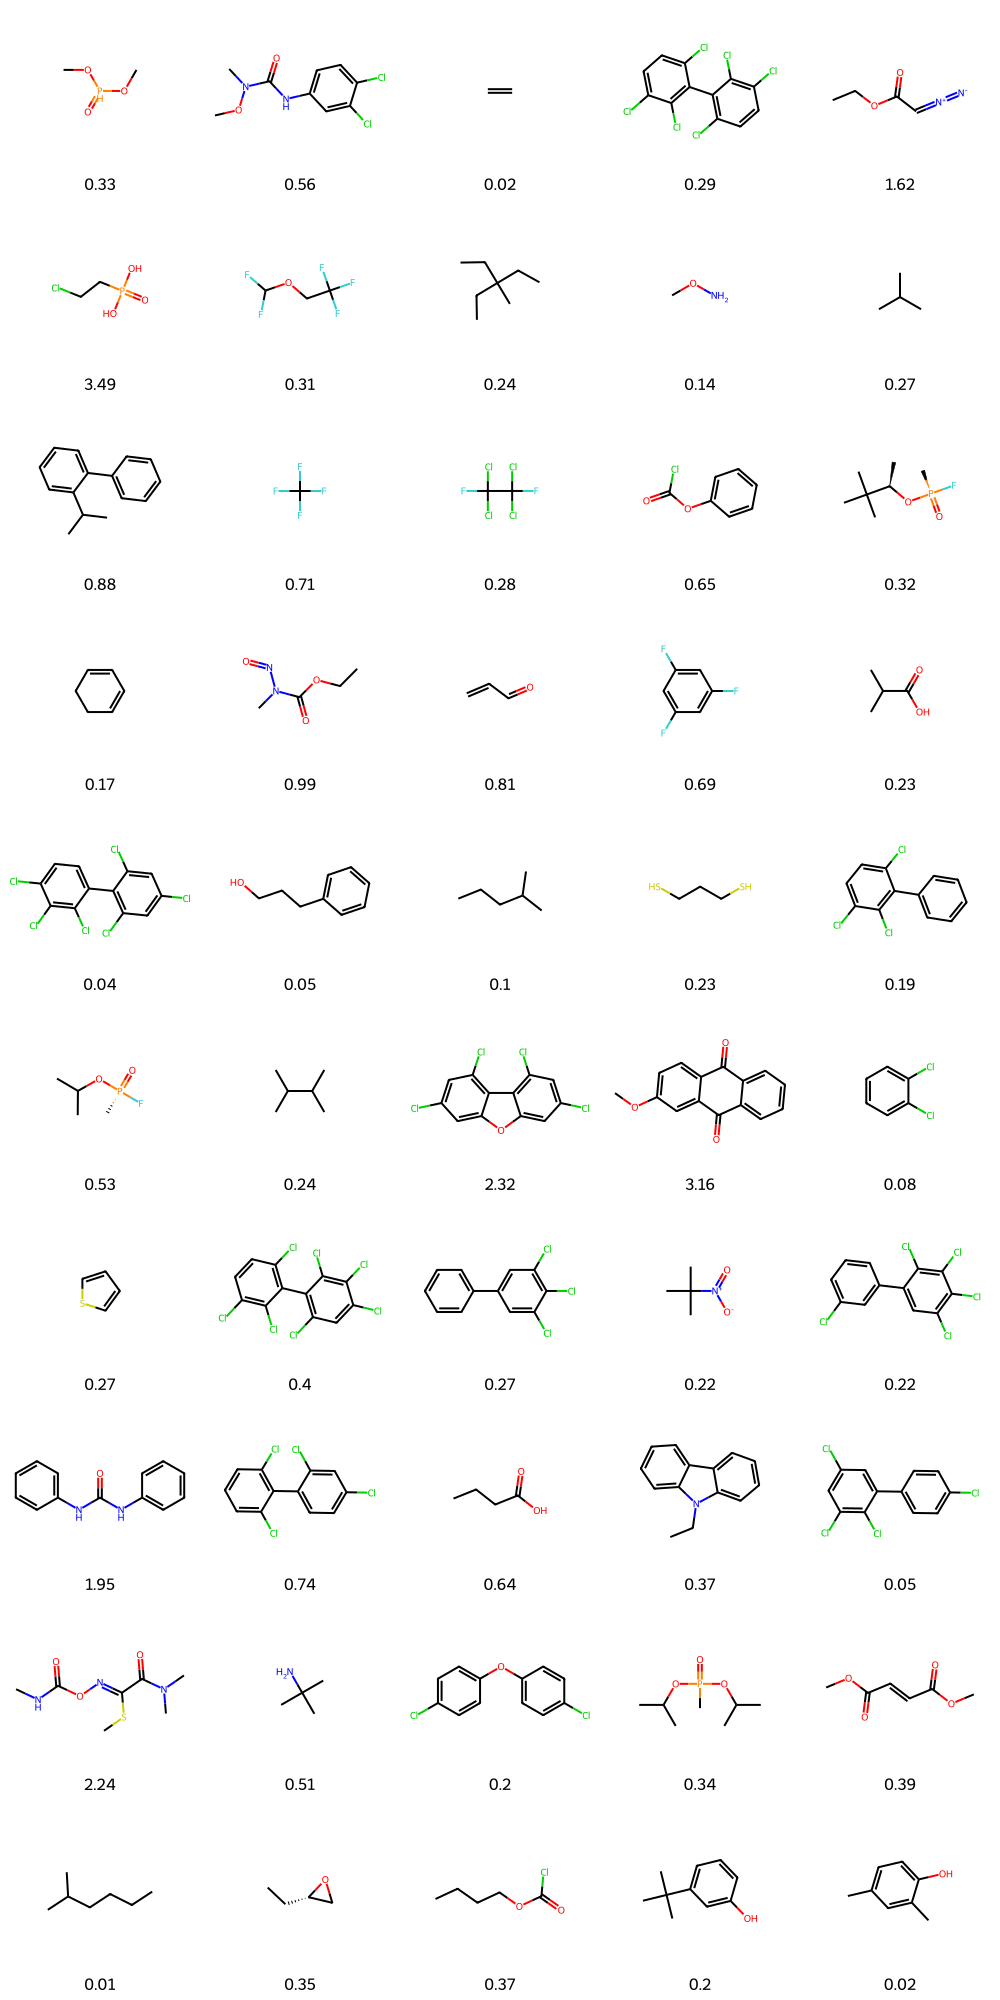

In [504]:
rigid_db = df_results_xgboost_physchem_copy[df_results_xgboost_physchem_copy['flexibility']== 'low']
rigid_db['molblcok'] = rigid_db.index.map(molregno_to_molblock)
rigid_db['ROMol'] = rigid_db['molblcok'].apply(lambda x: Chem.MolFromMolBlock(x))
rigid_db['ROMol'] = rigid_db['ROMol'].apply(lambda x: Chem.MolFromSmiles(Chem.MolToSmiles(x)))
from rdkit.Chem import PandasTools
# PandasTools.AddMoleculeColumnToFrame(flex_db, 'ROMol')
rigid_db['AE_rounded'] = rigid_db['AE'].round(2)
#get idx 50-100
rigid_db_tmp = rigid_db.iloc[50:100]
img = PandasTools.FrameToGridImage(rigid_db_tmp, molsPerRow=5, legendsCol='AE_rounded', subImgSize=(200, 200))
img

,Pred_Physchem,vp_log10_pa,molregno,ntabs,log10ntabs,AE,ntabs_cat
372,-5.295990,1.866521,2875,531441,5.725455,7.162512,high
1406,0.527101,5.758602,2506,1,0.000000,5.231500,low
4094,-5.475006,-0.398000,16237,2160,3.334454,5.077006,medium
4137,0.726213,-4.291898,585,30,1.477121,5.018111,low
5346,-6.453837,1.866521,2875,531441,5.725455,8.320359,high


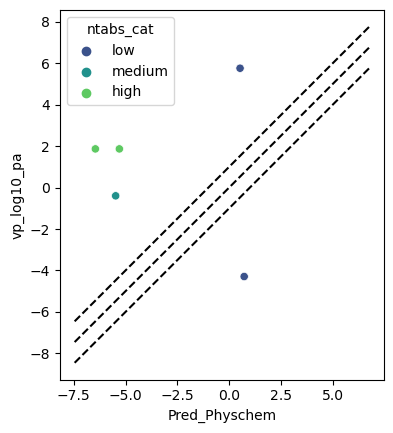

In [379]:
df_results_xgboost_physchem_high_errror = df_results_xgboost_physchem[df_results_xgboost_physchem['AE'] > 5]

#same plot, but only errors > 2
plt.figure()
sns.scatterplot(x='Pred_Physchem', y='vp_log10_pa', data=df_results_xgboost_physchem_high_errror, hue='ntabs_cat', palette='viridis')
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem_high_errror['vp_log10_pa'].min(), df_results_xgboost_physchem_high_errror['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem_high_errror['vp_log10_pa'].max(), df_results_xgboost_physchem_high_errror['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_Physchem')
#make square
plt.gca().set_aspect('equal', adjustable='box')
df_results_xgboost_physchem_high_errror

In [385]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils
#using our standard settings for our databse cs_mdfps
config = lwreg.utils.defaultConfig()
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'lebanon'
config['user'] = 'cschiebroek'
config['password'] = '' 
config['standardization'] = standardization_lib.RemoveHs()
config['registerConformers'] = True

molregnos = df_results_xgboost_physchem_high_errror['molregno'].unique().tolist()
queries = lwreg.query(config=config,ids=molregnos)
queries

[(585, 1730),
 (2506, 2504),
 (2875, 2873),
 (585, 6409),
 (585, 6410),
 (585, 6411),
 (585, 6412),
 (585, 6413),
 (2875, 8689),
 (2875, 8690),
 (2875, 8691),
 (2875, 8692),
 (2875, 8693),
 (2506, 14309),
 (2506, 14310),
 (2506, 14311),
 (2506, 14307),
 (2506, 14308),
 (16237, 16235)]

In [398]:
r = lwreg.retrieve(config=config,ids=[q])
r[0]

(16237,
 16235,
 '[H]C#CC([H])([H])S(=O)(=O)O[C@@]1([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[C@]1([H])Oc1c([H])c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c([H])c1[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 24 25 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 5.424840 4.483100 -0.447842 0\nM  V30 2 C 5.294140 3.311577 -0.009846 0\nM  V30 3 C 5.164312 2.051474 0.483432 0\nM  V30 4 S 4.050637 1.076689 -0.648268 0 VAL=6\nM  V30 5 O 3.482327 1.906292 -1.717262 0\nM  V30 6 O 4.970689 0.004659 -1.330959 0\nM  V30 7 O 3.053910 0.222950 0.332751 0\nM  V30 8 C 2.781827 -1.063240 0.056329 0 CFG=1\nM  V30 9 C 3.616373 -1.977372 0.987159 0\nM  V30 10 C 3.225754 -3.367674 0.768599 0\nM  V30 11 C 2.215721 -3.533660 -0.339069 0\nM  V30 12 C 0.996922 -2.715794 -0.125071 0\nM  V30 13 C 1.345711 -1.292580 0.375024 0 CFG=2\nM  V30 14 O 0.549613 -0.407752 -0.388890 0\nM  V30 15 C -0.635866 0.165265 -0.078611 0\nM  V30 16 C -1.555274 0.

In [399]:
retreivals = []
molregnos_seen = []
for q in queries:
    r = lwreg.retrieve(config=config,ids=[q])
    if r[0][0] not in molregnos_seen:
        molregnos_seen.append(r[0][0])
        retreivals.append(r)

In [406]:
df_results_xgboost_physchem_high_errror

,Pred_Physchem,vp_log10_pa,molregno,ntabs,log10ntabs,AE,ntabs_cat
372,-5.295990,1.866521,2875,531441,5.725455,7.162512,high
1406,0.527101,5.758602,2506,1,0.000000,5.231500,low
4094,-5.475006,-0.398000,16237,2160,3.334454,5.077006,medium
4137,0.726213,-4.291898,585,30,1.477121,5.018111,low
5346,-6.453837,1.866521,2875,531441,5.725455,8.320359,high


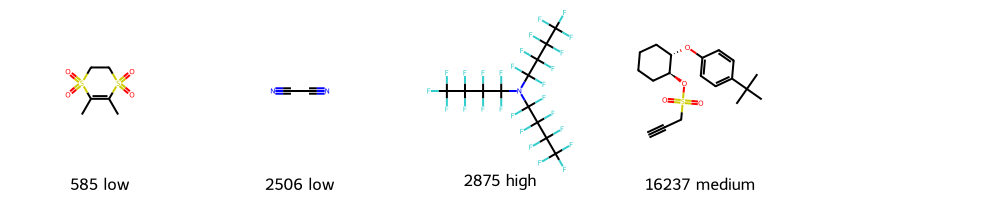

In [405]:
molblocls = [r[0][2] for r in retreivals]
molregnos = [r[0][0] for r in retreivals]
cats = [] 
for m in molregnos:
    cat = df_results_xgboost_physchem_high_errror[df_results_xgboost_physchem_high_errror['molregno'] == m]['ntabs_cat'].values[0]
    cats.append(cat)
mols = [Chem.MolFromMolBlock(mb) for mb in molblocls]
mols_2d = [Chem.AllChem.Compute2DCoords(mol) for mol in mols]
img = Chem.Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=[f'{m} {c}' for m,c in zip(molregnos, cats)])
img

In [ ]:
#plot pred against vp_log10_pa, color by ntabs
plt.figure()
sns.scatterplot(x='Pred_Physchem', y='vp_log10_pa', data=df_results_xgboost_physchem, hue='log10ntabs',size='log10ntabs')
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem['vp_log10_pa'].min(), df_results_xgboost_physchem['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem['vp_log10_pa'].max(), df_results_xgboost_physchem['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_Physchem')
#make square    
plt.gca().set_aspect('equal', adjustable='box')


In [315]:
#save molregno_to_ntabs as pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/molregno_to_ntabs.pkl', 'wb') as f:
    pickle.dump(molregno_to_ntabs, f)


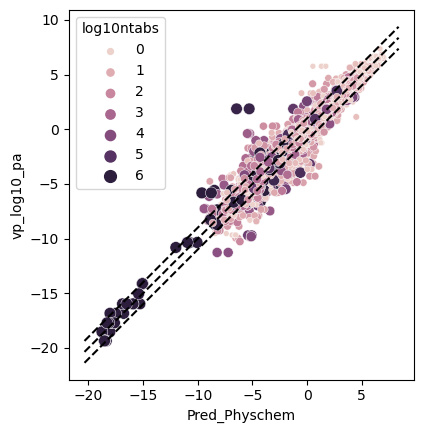

In [316]:
#plot pred against vp_log10_pa, color by ntabs
plt.figure()
sns.scatterplot(x='Pred_Physchem', y='vp_log10_pa', data=df_results_xgboost_physchem, hue='log10ntabs',size='log10ntabs')
#draw diagonal from min to max
min_val = min(df_results_xgboost_physchem['vp_log10_pa'].min(), df_results_xgboost_physchem['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem['vp_log10_pa'].max(), df_results_xgboost_physchem['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_Physchem')
#make square    
plt.gca().set_aspect('equal', adjustable='box')


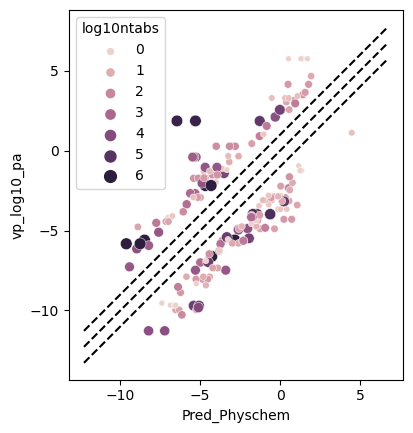

In [318]:
df_results_xgboost_physchem['AE_physchem'] = abs(df_results_xgboost_physchem['Pred_Physchem'] - df_results_xgboost_physchem['vp_log10_pa'])
df_results_xgboost_physchem_error_over_1 = df_results_xgboost_physchem[df_results_xgboost_physchem['AE_physchem'] > 2]
plt.figure()
sns.scatterplot(x='Pred_Physchem', y='vp_log10_pa', data=df_results_xgboost_physchem_error_over_1, hue='log10ntabs',size='log10ntabs')
min_val = min(df_results_xgboost_physchem_error_over_1['vp_log10_pa'].min(), df_results_xgboost_physchem_error_over_1['Pred_Physchem'].min()) -1
max_val = max(df_results_xgboost_physchem_error_over_1['vp_log10_pa'].max(), df_results_xgboost_physchem_error_over_1['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_Physchem')
#make square    
plt.gca().set_aspect('equal', adjustable='box')



log10ntabs_bin
(-0.006, 1.0]    0.253721
(1.0, 2.0]       0.283934
(2.0, 3.0]       0.274348
(3.0, 4.0]       0.387724
(4.0, 5.0]       0.358840
(5.0, 6.0]       0.439088
Name: AE_physchem, dtype: float64


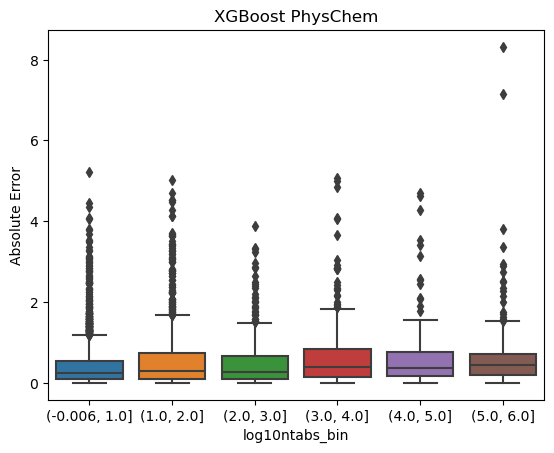

In [319]:
df_results_xgboost_physchem['AE_physchem'] = abs(df_results_xgboost_physchem['Pred_Physchem'] - df_results_xgboost_physchem['vp_log10_pa'])
#make log10ntabs bins (0-6)
df_results_xgboost_physchem['log10ntabs_bin'] = pd.cut(df_results_xgboost_physchem['log10ntabs'], bins=6)
#plot AE against log10ntabs_bin
plt.figure()
sns.boxplot(x='log10ntabs_bin', y='AE_physchem', data=df_results_xgboost_physchem)
plt.ylabel('Absolute Error')
plt.title('XGBoost PhysChem')
#print median AE for each bin
print(df_results_xgboost_physchem.groupby('log10ntabs_bin')['AE_physchem'].median())

log10ntabs_bin
(-0.006, 1.0]    0.327792
(1.0, 2.0]       0.397780
(2.0, 3.0]       0.363639
(3.0, 4.0]       0.472538
(4.0, 5.0]       0.430907
(5.0, 6.0]       0.506626
Name: AE_MDFP, dtype: float64


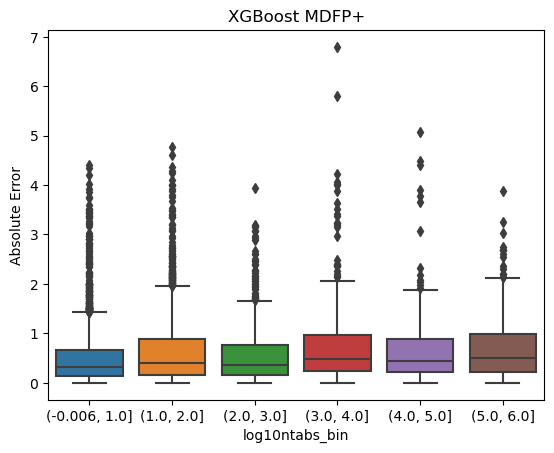

In [320]:

with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_MDFP.pkl', 'rb') as f:
    data_xgboost_mdfp_plus = pickle.load(f)
pred_list_xgboost_mdfp_plus = data_xgboost_mdfp_plus['pred_list']
ys_list_xgboost_mdfp_plus = data_xgboost_mdfp_plus['ys_list']
molregnos_xgboost_mdfp_plus = data_xgboost_mdfp_plus['molregnos']

pred_list_xgboost_mdfp_plus_flat = [item for sublist in pred_list_xgboost_mdfp_plus for item in sublist]
ys_list_xgboost_mdfp_plus_flat = [item for sublist in ys_list_xgboost_mdfp_plus for item in sublist]
molregnos_xgboost_mdfp_plus_flat = [item for sublist in molregnos_xgboost_mdfp_plus for item in sublist]
df_results_xgboost_mdfp_plus = pd.DataFrame({'Pred_MDFP': pred_list_xgboost_mdfp_plus_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_plus_flat, 'molregno': molregnos_xgboost_mdfp_plus_flat})
df_results_xgboost_mdfp_plus = df_results_xgboost_mdfp_plus[df_results_xgboost_mdfp_plus['molregno'].isin(df_confs_organic['molregno'])]
df_results_xgboost_mdfp_plus['ntabs'] = df_results_xgboost_mdfp_plus['molregno'].apply(lambda x: molregno_to_ntabs[x])
df_results_xgboost_mdfp_plus['log10ntabs'] = np.log10(df_results_xgboost_mdfp_plus['ntabs'])
df_results_xgboost_mdfp_plus['AE_MDFP'] = abs(df_results_xgboost_mdfp_plus['Pred_MDFP'] - df_results_xgboost_mdfp_plus['vp_log10_pa'])
#make log10ntabs bins (0-6)
df_results_xgboost_mdfp_plus['log10ntabs_bin'] = pd.cut(df_results_xgboost_mdfp_plus['log10ntabs'], bins=6)
#plot AE against log10ntabs_bin
plt.figure()
sns.boxplot(x='log10ntabs_bin', y='AE_MDFP', data=df_results_xgboost_mdfp_plus)
plt.ylabel('Absolute Error')
plt.title('XGBoost MDFP+')
#print median AE for each bin
print(df_results_xgboost_mdfp_plus.groupby('log10ntabs_bin')['AE_MDFP'].median())



In [452]:
df_results_combined = df_results_xgboost_physchem.merge(df_results_xgboost_mdfp_plus, on='molregno', suffixes=('_physchem', '_mdfp_plus'))
#rename AE to AE_physchem 
df_results_combined = df_results_combined.rename(columns={'AE': 'AE_physchem'})

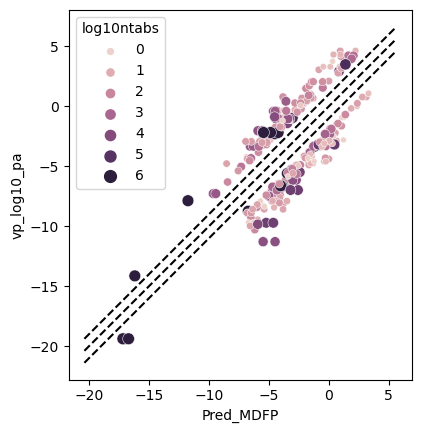

In [321]:
df_results_xgboost_mdfp_error_over_1 = df_results_xgboost_mdfp_plus[df_results_xgboost_mdfp_plus['AE_MDFP'] > 2]
plt.figure()
sns.scatterplot(x='Pred_MDFP', y='vp_log10_pa', data=df_results_xgboost_mdfp_error_over_1, hue='log10ntabs',size='log10ntabs')
min_val = min(df_results_xgboost_mdfp_error_over_1['vp_log10_pa'].min(), df_results_xgboost_mdfp_error_over_1['Pred_MDFP'].min()) -1
max_val = max(df_results_xgboost_mdfp_error_over_1['vp_log10_pa'].max(), df_results_xgboost_mdfp_error_over_1['Pred_MDFP'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_MDFP')
#make square    
plt.gca().set_aspect('equal', adjustable='box')



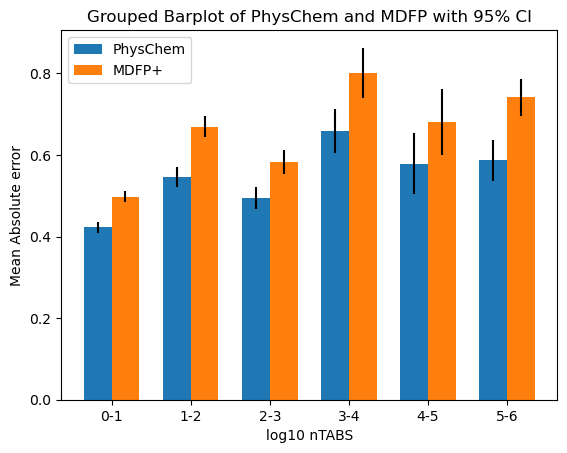

log10ntabs_bin
(-0.006, 1.0]    0.422409
(1.0, 2.0]       0.545954
(2.0, 3.0]       0.495367
(3.0, 4.0]       0.658940
(4.0, 5.0]       0.578968
(5.0, 6.0]       0.586550
Name: AE_physchem, dtype: float64
log10ntabs_bin
(-0.006, 1.0]    0.497919
(1.0, 2.0]       0.668561
(2.0, 3.0]       0.583188
(3.0, 4.0]       0.801730
(4.0, 5.0]       0.679937
(5.0, 6.0]       0.740950
Name: AE_MDFP, dtype: float64


In [454]:
import seaborn as sns
import numpy as np
import numpy as np
#barplot of median AE for each bin, for mdfp and physchem. error bar as 95% CI

#combine on molregno, suffices Physchem and MDFP
import matplotlib.pyplot as plt

# FILEPATH: /localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/015_Further_curation_and_downsampling.ipynb

# Create a list of ntabs bins

import matplotlib.pyplot as plt
# Get unique bins
df_results = df_results_combined.copy()
bins = df_results['log10ntabs_bin'].unique().sort_values()

# Get mean values for PhysChem and MDFP
physchem_means = df_results.groupby('log10ntabs_bin')['AE_physchem'].mean()
mdfp_means = df_results.groupby('log10ntabs_bin')['AE_MDFP'].mean()


# Get 95% confidence intervals for PhysChem and MDFP
physchem_ci = 1.96 * df_results.groupby('log10ntabs_bin')['AE_physchem'].std() / np.sqrt(df_results.groupby('log10ntabs_bin')['AE_physchem'].count())
mdfp_ci = 1.96 * df_results.groupby('log10ntabs_bin')['AE_MDFP'].std() / np.sqrt(df_results.groupby('log10ntabs_bin')['AE_MDFP'].count())
# Set the width of each bar
bar_width = 0.35

# Set the x positions of the bars
x = np.arange(len(bins))

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the PhysChem bars with error bars
ax.bar(x - bar_width/2, physchem_means, bar_width, yerr=physchem_ci, label='PhysChem')

# Plot the MDFP bars with error bars
ax.bar(x + bar_width/2, mdfp_means, bar_width, yerr=mdfp_ci, label='MDFP+')

# Set the x-axis labels
ax.set_xticks(x)
bins_str = [str(b)[1:-1] for b in bins]
bins_str[0] = '0.0-1.0'
bins_str = [b.replace(', ', '-') for b in bins_str]
bins_str = [b.replace('.0', '') for b in bins_str]
bins_str
ax.set_xticklabels(bins_str)

# Set the y-axis label
ax.set_ylabel('Mean Absolute error')
ax.set_xlabel('log10 nTABS')

# Set the title
ax.set_title('Grouped Barplot of PhysChem and MDFP with 95% CI')

# Add a legend
ax.legend(loc = 'upper left')

# Show the plot
plt.show()

#print out the resutl to check the labels
print(physchem_means)
print(mdfp_means)



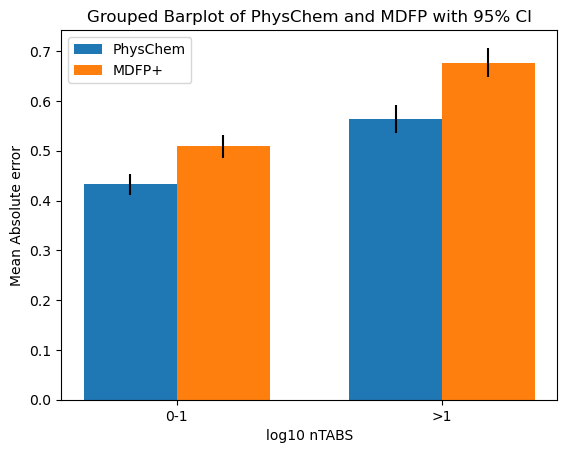

binary_bin
0-1    0.43225
>1     0.56330
Name: AE_physchem, dtype: float64
binary_bin
0-1    0.509287
>1     0.677093
Name: AE_MDFP, dtype: float64


In [363]:
import seaborn as sns
import numpy as np
import numpy as np
#barplot of median AE for each bin, for mdfp and physchem. error bar as 95% CI
df_results_xgboost_physchem['model'] = 'PhysChem'
df_results_xgboost_mdfp_plus['model'] = 'MDFP'
df_results = pd.concat([df_results_xgboost_physchem, df_results_xgboost_mdfp_plus])
#make another binnning: 0-1 log10ntabs, >1 log10ntabs
df_results['binary_bin'] = pd.cut(df_results['log10ntabs'], bins=[-1,1,7], labels=['0-1', '>1'])

import matplotlib.pyplot as plt

# FILEPATH: /localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/015_Further_curation_and_downsampling.ipynb

# Create a list of ntabs bins

import matplotlib.pyplot as plt
# Get unique bins

bins = df_results['binary_bin'].unique().sort_values()

# Get mean values for PhysChem and MDFP
physchem_means = df_results[df_results['model'] == 'PhysChem'].groupby('binary_bin')['AE_physchem'].mean()
mdfp_means = df_results[df_results['model'] == 'MDFP'].groupby('binary_bin')['AE_MDFP'].mean()

# Get 95% confidence intervals for PhysChem and MDFP
physchem_ci = df_results[df_results['model'] == 'PhysChem'].groupby('binary_bin')['AE_physchem'].std() * 1.96 / np.sqrt(df_results[df_results['model'] == 'PhysChem'].groupby('binary_bin')['AE_physchem'].count())
mdfp_ci = df_results[df_results['model'] == 'MDFP'].groupby('binary_bin')['AE_MDFP'].std() * 1.96 / np.sqrt(df_results[df_results['model'] == 'MDFP'].groupby('binary_bin')['AE_MDFP'].count())

# Set the width of each bar
bar_width = 0.35

# Set the x positions of the bars
x = np.arange(len(bins))

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the PhysChem bars with error bars
ax.bar(x - bar_width/2, physchem_means, bar_width, yerr=physchem_ci, label='PhysChem')

# Plot the MDFP bars with error bars
ax.bar(x + bar_width/2, mdfp_means, bar_width, yerr=mdfp_ci, label='MDFP+')

# Set the x-axis labels
ax.set_xticks(x)
# bins_str = [str(b)[1:-1] for b in bins]
# bins_str[0].replace('-0.006', '0.0')
# bins_str = [b.replace(', ', '-') for b in bins_str]
# bins_str = [b.replace('.0', '') for b in bins_str]
# bins_str
ax.set_xticklabels(bins)

# Set the y-axis label
ax.set_ylabel('Mean Absolute error')
ax.set_xlabel('log10 nTABS')

# Set the title
ax.set_title('Grouped Barplot of PhysChem and MDFP with 95% CI')

# Add a legend
ax.legend(loc = 'upper left')

# Show the plot
plt.show()

#print out the resutl to check the labels
print(physchem_means)
print(mdfp_means)


In [324]:
df_results_one_mol = df_results.drop_duplicates(subset='molregno')         #drop duplicates on molregno
df_results_one_mol

,Pred_Physchem,vp_log10_pa,molregno,ntabs,log10ntabs,AE_physchem,log10ntabs_bin,model,Pred_MDFP,AE_MDFP,binary_bin
0,0.370248,-0.176098,17139,1,0.000000,0.546346,"(-0.006, 1.0]",PhysChem,NaN,NaN,0-1
1,-1.214461,-0.959000,15772,137781,5.139189,0.255461,"(5.0, 6.0]",PhysChem,NaN,NaN,>1
3,-4.958812,-4.574099,948,150,2.176091,0.384714,"(2.0, 3.0]",PhysChem,NaN,NaN,>1
4,4.191795,3.368401,3705,15,1.176091,0.823394,"(1.0, 2.0]",PhysChem,NaN,NaN,>1
5,0.517101,0.054802,3104,6561,3.816970,0.462299,"(3.0, 4.0]",PhysChem,NaN,NaN,>1
...,...,...,...,...,...,...,...,...,...,...,...
5445,-4.255780,-3.886098,3113,1008,3.003461,0.369682,"(3.0, 4.0]",PhysChem,NaN,NaN,>1
5452,-0.728171,0.242203,333,6,0.778151,0.970374,"(-0.006, 1.0]",PhysChem,NaN,NaN,0-1
5458,4.305128,4.113202,995,11,1.041393,0.191926,"(1.0, 2.0]",PhysChem,NaN,NaN,>1
5477,-5.688599,-5.574099,548,15,1.176091,0.114500,"(1.0, 2.0]",PhysChem,NaN,NaN,>1


([<matplotlib.axis.XTick at 0x7f8f68bb8890>,
 [Text(0, 0, '0-1'),
  Text(1, 0, '1-2'),
  Text(2, 0, '2-3'),
  Text(3, 0, '3-4'),
  Text(4, 0, '4-5'),
  Text(5, 0, '5-6')])

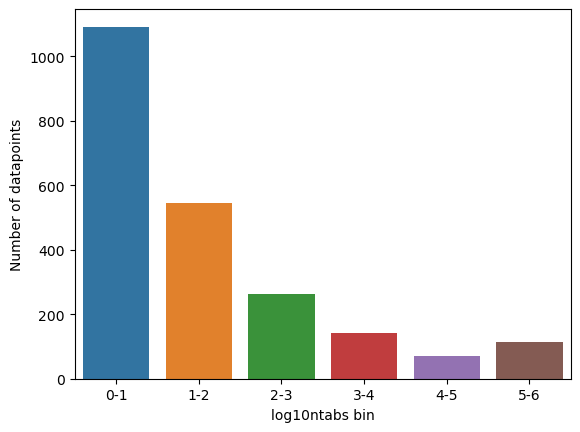

In [325]:
#barplot of number of datapoints per log10ntabs bin, using df_results_one_mol (dont care about model)
n_per_bin = df_results_one_mol['log10ntabs_bin'].value_counts().sort_index()
#plot
plt.figure()
sns.barplot(x=n_per_bin.index, y=n_per_bin.values)
plt.ylabel('Number of datapoints')
plt.xlabel('log10ntabs bin')
bins = df_results_one_mol['log10ntabs_bin'].unique().sort_values()
x = np.arange(len(bins))
# x = [i+0.5 for i in x]
bins_str = [str(b)[1:-1] for b in bins]
bins_str[0] = '0.0-1.0'
bins_str = [b.replace(', ', '-') for b in bins_str]
bins_str = [b.replace('.0', '') for b in bins_str]
plt.xticks(x, bins_str)


In [327]:
#drop categorical colums
df_results_xgboost_physchem_mean = df_results_xgboost_physchem.drop(columns=['ntabs', 'log10ntabs_bin'])
df_results_xgboost_physchem_mean = df_results_xgboost_physchem_mean.groupby('molregno').mean()
df_results_xgboost_physchem_mean

TypeError: agg function failed [how->mean,dtype->object]

/tmp/ipykernel_2218393/3945988196.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_confs_organic['vp_log10_pa_bin'] = pd.cut(df_confs_organic['vp_log10_pa'], bins=[-20, -5, 0, 10])


Text(0, 0.5, 'Number of datapoints')

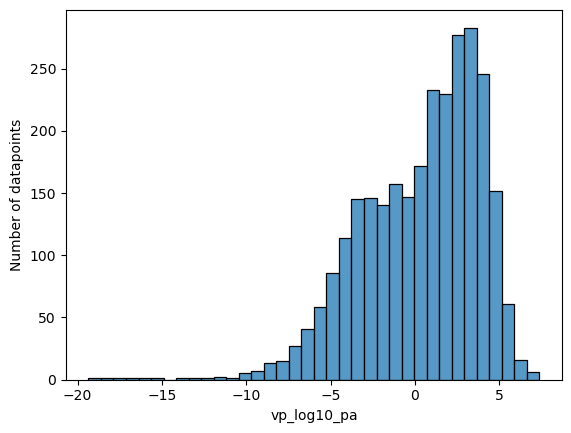

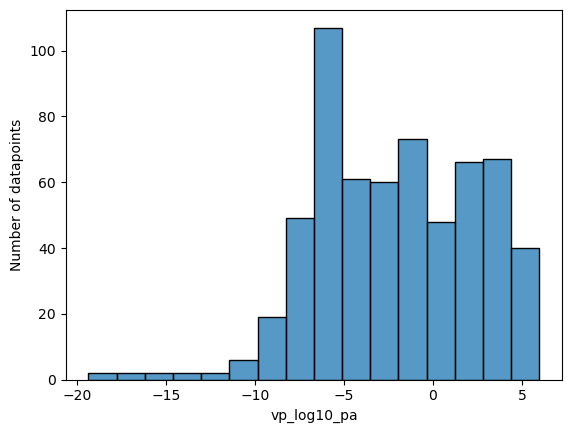

In [328]:
#barplot of vp_log1o_pa from df_confs
plt.figure()
sns.histplot(df_confs_organic['vp_log10_pa'])
plt.xlabel('vp_log10_pa')
plt.ylabel('Number of datapoints')
#now do downsampling, so same amount of datapoints in <-5, -5-0,>0
df_confs_organic['vp_log10_pa_bin'] = pd.cut(df_confs_organic['vp_log10_pa'], bins=[-20, -5, 0, 10])
n_per_bin = df_confs_organic['vp_log10_pa_bin'].value_counts().sort_index()
df_downsampling = df_confs_organic.groupby('vp_log10_pa_bin').apply(lambda x: x.sample(n=min(n_per_bin.values)))
plt.figure()
sns.histplot(df_downsampling['vp_log10_pa'])
plt.xlabel('vp_log10_pa')
plt.ylabel('Number of datapoints')

In [329]:
#first experiment: XGBoost PhysicalChem Descriptors
import xgboost as xgb
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def XGBOOST_random_splits(params, descriptors,train_dfs,val_dfs):
    pred_list,ys_list,molregnos = [],[],[]
    i = 0
    for df_train,df_val in zip(train_dfs,val_dfs):
        train_X = df_train[descriptors]
        train_y = df_train['vp_log10_pa']
        val_X = df_val[descriptors]
        val_y = df_val['vp_log10_pa']
        dtrain = xgb.DMatrix(train_X, label=train_y)
        dval = xgb.DMatrix(val_X, label=val_y)
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            verbose_eval=False
        )
        preds = model.predict(dval)
        rmse = mean_squared_error(val_y, preds, squared=False)
        pred_list.append(preds)
        ys_list.append(val_y)
        molregnos.append(df_val['molregno'])
        print(f"Split {i + 1}: RMSE = {rmse}")
        i += 1
    return pred_list, ys_list, molregnos
  

In [330]:
df_train_list,df_val_list = [],[]
for i in range(10):
    df_train, df_val = train_test_split(df_downsampling, test_size=0.2)
    df_train_list.append(df_train)
    df_val_list.append(df_val)

In [331]:
params = { #hyperparameters optimized by Working Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
pred_list_xgboost_physchem, ys_list_xgboost_physchem, molregnos_xgboost_physchem = XGBOOST_random_splits(params, RDKit_feature_names, df_train_list, df_val_list)

Split 1: RMSE = 1.5865008415757753
Split 2: RMSE = 1.169019021904854
Split 3: RMSE = 1.1981187376903195
Split 4: RMSE = 1.240916906154822
Split 5: RMSE = 1.0007862944967052
Split 6: RMSE = 1.1389737265915034
Split 7: RMSE = 1.2221191607446928
Split 8: RMSE = 1.1804717548857606
Split 9: RMSE = 1.2514289268548384
Split 10: RMSE = 1.315217490596992


In [332]:
mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
                     'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
pred_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus = XGBOOST_random_splits(params, mdfp_features_all, df_train_list, df_val_list)

Split 1: RMSE = 1.8648336735329518
Split 2: RMSE = 1.7442330285423187
Split 3: RMSE = 1.6189083837446638
Split 4: RMSE = 1.5099658472053705
Split 5: RMSE = 1.5049989884087291
Split 6: RMSE = 1.2687594146818721
Split 7: RMSE = 1.4667934415502115
Split 8: RMSE = 1.3040179442747912
Split 9: RMSE = 1.6723760460450279
Split 10: RMSE = 1.4342318410501447


In [333]:
mdfp_features_sim_only = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
pred_list_xgboost_mdfp_and_physchem, ys_list_xgboost_mdfp_and_physchem, molregnos_xgboost_mdfp_and_physchem = XGBOOST_random_splits(params, mdfp_features_sim_only + list(RDKit_feature_names), df_train_list, df_val_list)

Split 1: RMSE = 1.58048343386009
Split 2: RMSE = 1.1834249637872962
Split 3: RMSE = 1.2114029641094894
Split 4: RMSE = 1.2610179782293114
Split 5: RMSE = 1.084195273173638
Split 6: RMSE = 1.177985796142741
Split 7: RMSE = 1.3485380075022977
Split 8: RMSE = 1.225480082496364
Split 9: RMSE = 1.1720785258028434
Split 10: RMSE = 1.3169750348669602


In [334]:
preds_2d_baseline, ys_2d_baseline, molregnos_2d_baseline = XGBOOST_random_splits(params, ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI'], df_train_list, df_val_list)

Split 1: RMSE = 2.1083591082076567
Split 2: RMSE = 2.1125382593999635
Split 3: RMSE = 1.8887986377680321
Split 4: RMSE = 2.062600969081892
Split 5: RMSE = 1.8381699257920532
Split 6: RMSE = 1.627391544063626
Split 7: RMSE = 1.8199011676197092
Split 8: RMSE = 1.464740500733719
Split 9: RMSE = 2.0923326611984483
Split 10: RMSE = 1.7649651875081462


In [335]:
mdfp_features_sim_only = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
preds_mdfp_only, ys_mdfp_only, molregnos_mdfp_only = XGBOOST_random_splits(params, mdfp_features_sim_only, df_train_list, df_val_list)

Split 1: RMSE = 1.9845708083345042
Split 2: RMSE = 1.856420503698148
Split 3: RMSE = 1.9526124315944449
Split 4: RMSE = 1.908732996504558
Split 5: RMSE = 1.7047672916397982
Split 6: RMSE = 1.6245750175678153
Split 7: RMSE = 1.7329341226123434
Split 8: RMSE = 1.6671909254276145
Split 9: RMSE = 1.8331026194704354
Split 10: RMSE = 1.653498257539389


In [336]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, print_stats=True, bounds=None, title=None, print_spearman=False, name=None, dims = (1, 3)):
    # fig, axes = plt.subplots(1, len(reals_list), figsize=(10 * len(reals_list), 8))
    #assert that len(reals_list) is smaller then the number of subplots
    assert len(reals_list) <= dims[0]*dims[1]
    fig, axes = plt.subplots(dims[0], dims[1], figsize=(10 * dims[1], 8 * dims[0]))
    axes = axes.flatten()
    for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
        ax = axes[i] if len(reals_list) > 1 else axes


    # for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
    #     ax = axes[i] if len(reals_list) > 1 else axes

        rmses, maes, ebos, kts, median_aes = [], [], [], [], []

        for r, p in zip(reals, predictions):
            RMSE, MAE, EBO, KT, median_AE = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)
            median_aes.append(median_AE)

        rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
        rmse_mean = np.mean(rmses)
        mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
        median_AE_mean = np.mean(median_aes)

        mrn = [item for sublist in molregnos for item in sublist]
        real = [item for sublist in reals for item in sublist]
        prediction = [item for sublist in predictions for item in sublist]

        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()

        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')

        # dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        # z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")

        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]

        ax.axis([lower, upper, lower, upper])

        text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})',
                           transform=ax.transAxes, fontsize=12, verticalalignment='top',
                           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        if title is not None:
            ax.set_title(title[i] if len(reals_list) > 1 else title, fontsize=14)

        ax.set_aspect('equal', 'box')

    if name:
        plt.savefig(f'{name}.png', dpi=800, bbox_inches='tight')
    else:
        plt.show()


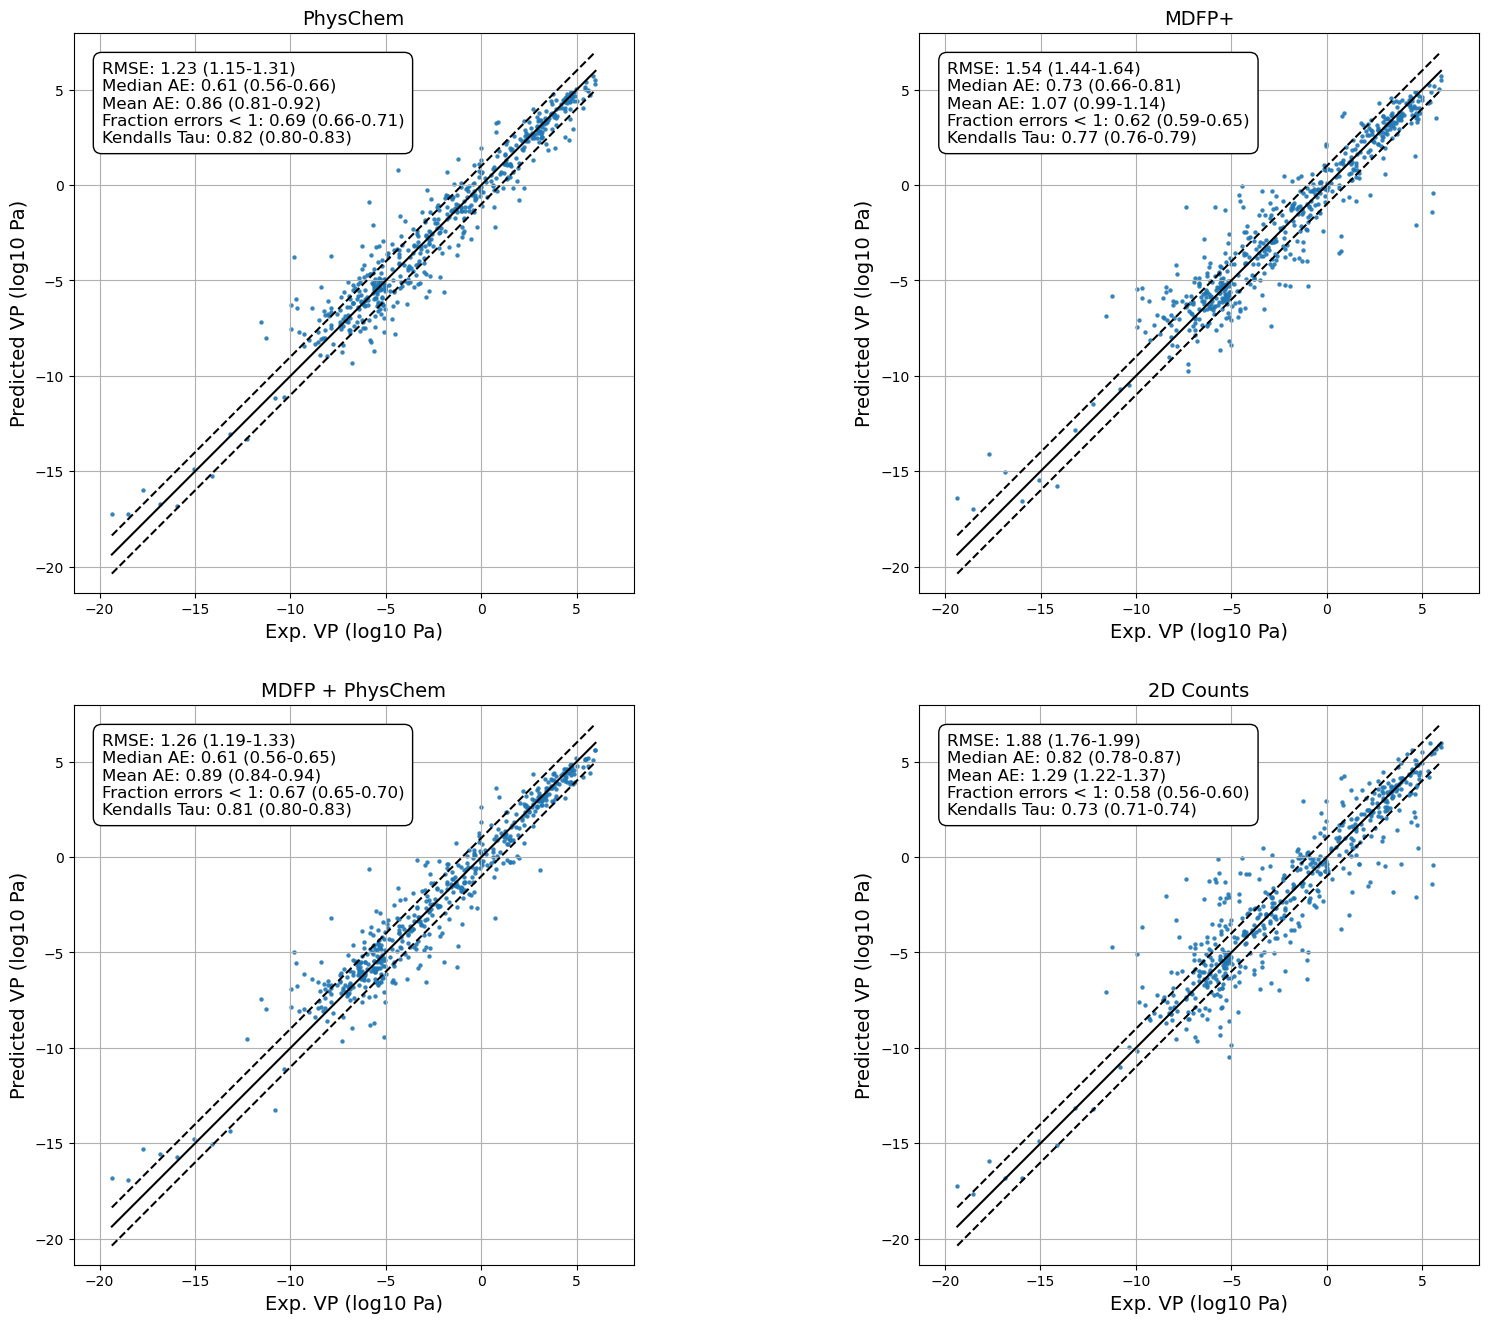

In [337]:
reals_list = [ys_list_xgboost_physchem, ys_list_xgboost_mdfp_plus, ys_list_xgboost_mdfp_and_physchem, ys_2d_baseline, ]
predictions_list = [pred_list_xgboost_physchem, pred_list_xgboost_mdfp_plus, pred_list_xgboost_mdfp_and_physchem, preds_2d_baseline, ]
molregnos_list = [molregnos_xgboost_physchem, molregnos_xgboost_mdfp_plus, molregnos_xgboost_mdfp_plus, molregnos_2d_baseline, ]
title = ['PhysChem', 'MDFP+', 'MDFP + PhysChem', '2D Counts']
density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, title=title, name='XGBoost_MDFP_PhysChem',dims=(2,2))

In [338]:
#make flat lists
pred_list_xgboost_physchem_flat = [item for sublist in pred_list_xgboost_physchem for item in sublist]
ys_list_xgboost_physchem_flat = [item for sublist in ys_list_xgboost_physchem for item in sublist]
molregnos_xgboost_physchem_flat = [item for sublist in molregnos_xgboost_physchem for item in sublist]
pred_list_xgboost_mdfp_plus_flat = [item for sublist in pred_list_xgboost_mdfp_plus for item in sublist]
ys_list_xgboost_mdfp_plus_flat = [item for sublist in ys_list_xgboost_mdfp_plus for item in sublist]
molregnos_xgboost_mdfp_plus_flat = [item for sublist in molregnos_xgboost_mdfp_plus for item in sublist]
pred_list_xgboost_mdfp_and_physchem_flat = [item for sublist in pred_list_xgboost_mdfp_and_physchem for item in sublist]
ys_list_xgboost_mdfp_and_physchem_flat = [item for sublist in ys_list_xgboost_mdfp_and_physchem for item in sublist]
molregnos_xgboost_mdfp_and_physchem_flat = [item for sublist in molregnos_xgboost_mdfp_and_physchem for item in sublist]
preds_2d_baseline_flat = [item for sublist in preds_2d_baseline for item in sublist]
ys_2d_baseline_flat = [item for sublist in ys_2d_baseline for item in sublist]
molregnos_2d_baseline_flat = [item for sublist in molregnos_2d_baseline for item in sublist]

df_downsampled_physchem = pd.DataFrame({'Pred_Physchem': pred_list_xgboost_physchem_flat, 'vp_log10_pa': ys_list_xgboost_physchem_flat, 'molregno': molregnos_xgboost_physchem_flat})
df_downsampled_mdfp_plus = pd.DataFrame({'Pred_MDFP': pred_list_xgboost_mdfp_plus_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_plus_flat, 'molregno': molregnos_xgboost_mdfp_plus_flat})
df_downsampled_mdfp_and_physchem = pd.DataFrame({'Pred_MDFP_Physchem': pred_list_xgboost_mdfp_and_physchem_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_and_physchem_flat, 'molregno': molregnos_xgboost_mdfp_and_physchem_flat})
df_downsampled_2d_baseline = pd.DataFrame({'Pred_2D': preds_2d_baseline_flat, 'vp_log10_pa': ys_2d_baseline_flat, 'molregno': molregnos_2d_baseline_flat})

In [339]:
df_results = pd.concat([df_results_xgboost_physchem, df_results_xgboost_mdfp_plus], axis=1)
df_results = df_results.loc[:,~df_results.columns.duplicated()]
#vp_log10_pa as float, all preds as floats
df_results['vp_log10_pa'] = df_results['vp_log10_pa'].astype(float)
df_results['Pred_Physchem'] = df_results['Pred_Physchem'].astype(float)
df_results['Pred_MDFP'] = df_results['Pred_MDFP'].astype(float)
# #add column error PhysChem, error MDFP, error MDFP_PhysChem
df_results['error_PhysChem'] = df_results['vp_log10_pa'] - df_results['Pred_Physchem']
df_results['error_MDFP'] = df_results['vp_log10_pa'] - df_results['Pred_MDFP']
df_results

,Pred_Physchem,vp_log10_pa,molregno,ntabs,log10ntabs,AE_physchem,log10ntabs_bin,model,Pred_MDFP,AE_MDFP,error_PhysChem,error_MDFP
0,0.370248,-0.176098,17139,1,0.000000,0.546346,"(-0.006, 1.0]",PhysChem,0.392157,0.568255,-0.546346,-0.568255
1,-1.214461,-0.959000,15772,137781,5.139189,0.255461,"(5.0, 6.0]",PhysChem,-3.017217,2.058217,0.255461,2.058217
3,-4.958812,-4.574099,948,150,2.176091,0.384714,"(2.0, 3.0]",PhysChem,-3.832858,0.741240,0.384714,-0.741240
4,4.191795,3.368401,3705,15,1.176091,0.823394,"(1.0, 2.0]",PhysChem,2.854850,0.513551,-0.823394,0.513551
5,0.517101,0.054802,3104,6561,3.816970,0.462299,"(3.0, 4.0]",PhysChem,1.092970,1.038168,-0.462299,-1.038168
...,...,...,...,...,...,...,...,...,...,...,...,...
5495,2.615578,2.840000,15959,3,0.477121,0.224422,"(-0.006, 1.0]",PhysChem,3.136857,0.296857,0.224422,-0.296857
5496,2.376604,1.949000,16339,9,0.954243,0.427604,"(-0.006, 1.0]",PhysChem,1.686961,0.262039,-0.427604,0.262039
5497,2.712019,2.962502,2941,9,0.954243,0.250482,"(-0.006, 1.0]",PhysChem,3.809486,0.846984,0.250482,-0.846984
5498,1.549318,-0.260398,371,45,1.653213,1.809717,"(1.0, 2.0]",PhysChem,1.262549,1.522947,-1.809717,-1.522947


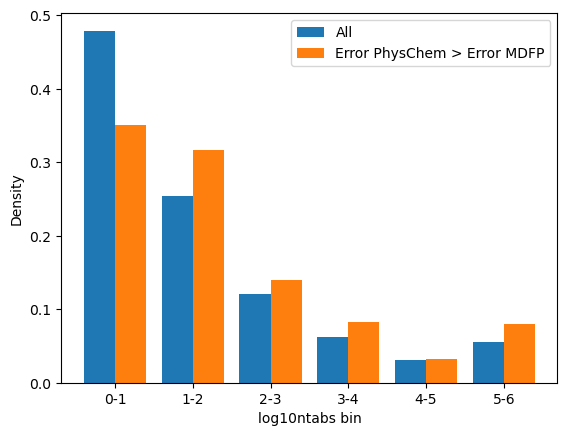

In [340]:
#make colums of error_physchem - error_mdfp
df_results['error_PhysChem-MDFP'] = df_results['error_PhysChem'] - df_results['error_MDFP']
df_results_physchem_worse = df_results[df_results['error_PhysChem-MDFP'] > 1]
df_results_physchem_worse
#density histogram of log10ntabs bin of this subset vs all (grouped)
plt.figure()
plt.hist([df_results['log10ntabs'], df_results_physchem_worse['log10ntabs']], bins=6, density=True, histtype='bar', label=['All', 'Error PhysChem > Error MDFP'])

bins = df_results['log10ntabs_bin'].unique().sort_values()
x = np.arange(len(bins))
x = [i+0.5 for i in x]
bins_str = [str(b)[1:-1] for b in bins]
bins_str[0] = '0.0-1.0'
bins_str = [b.replace(', ', '-') for b in bins_str]
bins_str = [b.replace('.0', '') for b in bins_str]
plt.xticks(x, bins_str)
plt.xlabel('log10ntabs bin')
plt.ylabel('Density')
plt.legend()
plt.show()



In [341]:
#make flat lists
pred_list_xgboost_physchem_flat = [item for sublist in pred_list_xgboost_physchem for item in sublist]
ys_list_xgboost_physchem_flat = [item for sublist in ys_list_xgboost_physchem for item in sublist]
molregnos_xgboost_physchem_flat = [item for sublist in molregnos_xgboost_physchem for item in sublist]
pred_list_xgboost_mdfp_plus_flat = [item for sublist in pred_list_xgboost_mdfp_plus for item in sublist]
ys_list_xgboost_mdfp_plus_flat = [item for sublist in ys_list_xgboost_mdfp_plus for item in sublist]
molregnos_xgboost_mdfp_plus_flat = [item for sublist in molregnos_xgboost_mdfp_plus for item in sublist]
pred_list_xgboost_mdfp_and_physchem_flat = [item for sublist in pred_list_xgboost_mdfp_and_physchem for item in sublist]
ys_list_xgboost_mdfp_and_physchem_flat = [item for sublist in ys_list_xgboost_mdfp_and_physchem for item in sublist]
molregnos_xgboost_mdfp_and_physchem_flat = [item for sublist in molregnos_xgboost_mdfp_and_physchem for item in sublist]
preds_2d_baseline_flat = [item for sublist in preds_2d_baseline for item in sublist]
ys_2d_baseline_flat = [item for sublist in ys_2d_baseline for item in sublist]
molregnos_2d_baseline_flat = [item for sublist in molregnos_2d_baseline for item in sublist]

df_downsampled_physchem = pd.DataFrame({'Pred_Physchem': pred_list_xgboost_physchem_flat, 'vp_log10_pa': ys_list_xgboost_physchem_flat, 'molregno': molregnos_xgboost_physchem_flat})
df_downsampled_mdfp_plus = pd.DataFrame({'Pred_MDFP': pred_list_xgboost_mdfp_plus_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_plus_flat, 'molregno': molregnos_xgboost_mdfp_plus_flat})
df_downsampled_mdfp_and_physchem = pd.DataFrame({'Pred_MDFP_Physchem': pred_list_xgboost_mdfp_and_physchem_flat, 'vp_log10_pa': ys_list_xgboost_mdfp_and_physchem_flat, 'molregno': molregnos_xgboost_mdfp_and_physchem_flat})
df_downsampled_2d_baseline = pd.DataFrame({'Pred_2D': preds_2d_baseline_flat, 'vp_log10_pa': ys_2d_baseline_flat, 'molregno': molregnos_2d_baseline_flat})

In [342]:
df_downsampled_physchem['ntabs'] = df_downsampled_physchem['molregno'].apply(lambda x: molregno_to_ntabs[x])
df_downsampled_physchem['log10ntabs'] = np.log10(df_downsampled_physchem['ntabs'])
df_downsampled_mdfp_plus['ntabs'] = df_downsampled_mdfp_plus['molregno'].apply(lambda x: molregno_to_ntabs[x])
df_downsampled_mdfp_plus['log10ntabs'] = np.log10(df_downsampled_mdfp_plus['ntabs'])
df_downsampled_mdfp_and_physchem['ntabs'] = df_downsampled_mdfp_and_physchem['molregno'].apply(lambda x: molregno_to_ntabs[x])
df_downsampled_mdfp_and_physchem['log10ntabs'] = np.log10(df_downsampled_mdfp_and_physchem['ntabs'])
df_downsampled_2d_baseline['ntabs'] = df_downsampled_2d_baseline['molregno'].apply(lambda x: molregno_to_ntabs[x])
df_downsampled_2d_baseline['log10ntabs'] = np.log10(df_downsampled_2d_baseline['ntabs'])

df_downsampled_physchem['AE_Physchem'] = abs(df_downsampled_physchem['Pred_Physchem'] - df_downsampled_physchem['vp_log10_pa'])
df_downsampled_mdfp_plus['AE_MDFP'] = abs(df_downsampled_mdfp_plus['Pred_MDFP'] - df_downsampled_mdfp_plus['vp_log10_pa'])


Text(0.5, 1.0, 'PhysChem downsampled, error > 2')

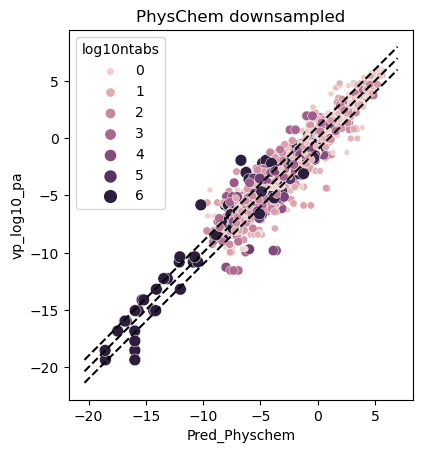

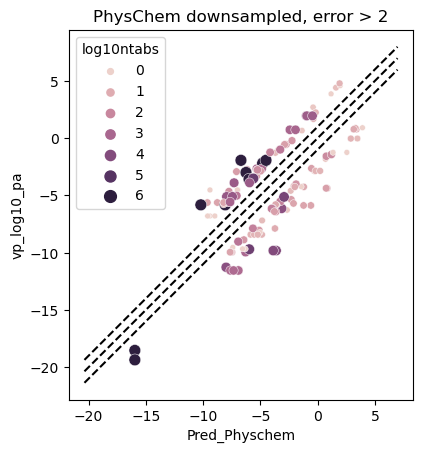

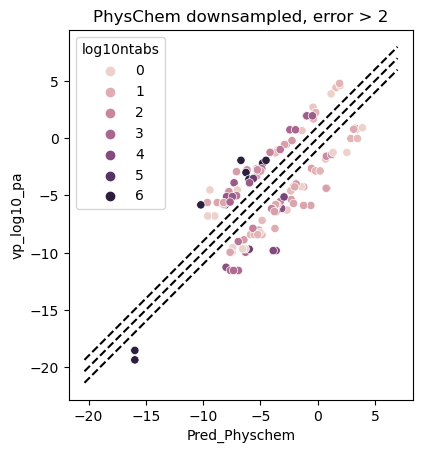

In [343]:
#plot pred against vp_log10_pa, color by ntabs
plt.figure()
sns.scatterplot(x='Pred_Physchem', y='vp_log10_pa', data=df_downsampled_physchem, hue='log10ntabs',size='log10ntabs')
#draw diagonal from min to max
min_val = min(df_downsampled_physchem['vp_log10_pa'].min(), df_downsampled_physchem['Pred_Physchem'].min()) -1
max_val = max(df_downsampled_physchem['vp_log10_pa'].max(), df_downsampled_physchem['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_Physchem')
#make square    
plt.gca().set_aspect('equal', adjustable='box')
plt.title('PhysChem downsampled')

#and plot only for error > 2
plt.figure()
sns.scatterplot(x='Pred_Physchem', y='vp_log10_pa', data=df_downsampled_physchem[df_downsampled_physchem['AE_Physchem'] > 2], hue='log10ntabs',size='log10ntabs')
#draw diagonal from min to max
min_val = min(df_downsampled_physchem['vp_log10_pa'].min(), df_downsampled_physchem['Pred_Physchem'].min()) -1
max_val = max(df_downsampled_physchem['vp_log10_pa'].max(), df_downsampled_physchem['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_Physchem')
#make square
plt.gca().set_aspect('equal', adjustable='box')
plt.title('PhysChem downsampled, error > 2')


plt.figure()
sns.scatterplot(x='Pred_Physchem', y='vp_log10_pa', data=df_downsampled_physchem[df_downsampled_physchem['AE_Physchem'] > 2], hue='log10ntabs')
#draw diagonal from min to max
min_val = min(df_downsampled_physchem['vp_log10_pa'].min(), df_downsampled_physchem['Pred_Physchem'].min()) -1
max_val = max(df_downsampled_physchem['vp_log10_pa'].max(), df_downsampled_physchem['Pred_Physchem'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_Physchem')
#make square
plt.gca().set_aspect('equal', adjustable='box')
plt.title('PhysChem downsampled, error > 2')



In [344]:
big_error_physchem_downsampled = df_downsampled_physchem[df_downsampled_physchem['AE_Physchem'] > 2]
n_0 = big_error_physchem_downsampled[big_error_physchem_downsampled['log10ntabs'] == 0].shape[0]
prob = n_0 / big_error_physchem_downsampled.shape[0] * 100
n_0_all = df_downsampled_physchem[df_downsampled_physchem['log10ntabs'] == 0].shape[0]
prob_all = n_0_all / df_downsampled_physchem.shape[0] * 100
print(prob_all,prob)
big_error_mdfp_downsampled = df_downsampled_mdfp_plus[df_downsampled_mdfp_plus['AE_MDFP'] > 2]
n_0 = big_error_mdfp_downsampled[big_error_mdfp_downsampled['log10ntabs'] == 0].shape[0]
prob = n_0 / big_error_mdfp_downsampled.shape[0] * 100
n_0_all = df_downsampled_mdfp_plus[df_downsampled_mdfp_plus['log10ntabs'] == 0].shape[0]
prob_all = n_0_all / df_downsampled_mdfp_plus.shape[0] * 100
print(prob_all,prob)

16.065573770491802 15.2
16.065573770491802 13.186813186813188


In [345]:
big_error_physchem_downsampled = df_downsampled_physchem[df_downsampled_physchem['AE_Physchem'] > 2]
n_0 = big_error_physchem_downsampled[big_error_physchem_downsampled['log10ntabs'] > 3].shape[0]
prob = n_0 / big_error_physchem_downsampled.shape[0] * 100
n_0_all = df_downsampled_physchem[df_downsampled_physchem['log10ntabs'] > 3].shape[0]
prob_all = n_0_all / df_downsampled_physchem.shape[0] * 100
print(prob_all,prob)
#same for mdfp
big_error_mdfp_downsampled = df_downsampled_mdfp_plus[df_downsampled_mdfp_plus['AE_MDFP'] > 2]
n_0 = big_error_mdfp_downsampled[big_error_mdfp_downsampled['log10ntabs']> 3].shape[0]
prob = n_0 / big_error_mdfp_downsampled.shape[0] * 100
n_0_all = df_downsampled_mdfp_plus[df_downsampled_mdfp_plus['log10ntabs'] > 3].shape[0]
prob_all = n_0_all / df_downsampled_mdfp_plus.shape[0] * 100
print(prob_all,prob)

19.918032786885245 21.6
19.918032786885245 16.483516483516482


Text(0.5, 1.0, 'MDFP downsampled, error > 2')

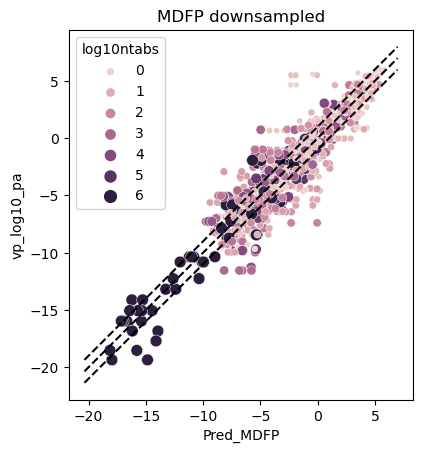

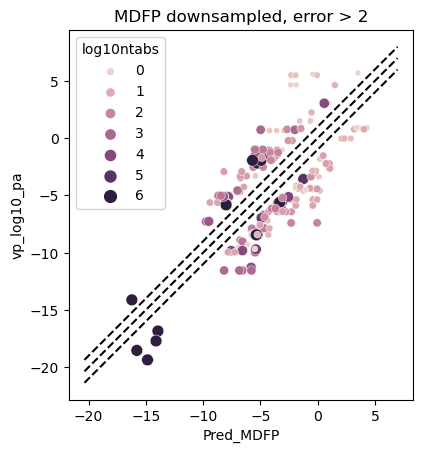

In [346]:
#plot pred against vp_log10_pa, color by ntabs
plt.figure()
sns.scatterplot(x='Pred_MDFP', y='vp_log10_pa', data=df_downsampled_mdfp_plus, hue='log10ntabs',size='log10ntabs')
#draw diagonal from min to max
min_val = min(df_downsampled_mdfp_plus['vp_log10_pa'].min(), df_downsampled_mdfp_plus['Pred_MDFP'].min()) -1
max_val = max(df_downsampled_mdfp_plus['vp_log10_pa'].max(), df_downsampled_mdfp_plus['Pred_MDFP'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_MDFP')
#make square    
plt.gca().set_aspect('equal', adjustable='box')
plt.title('MDFP downsampled')

#and plot only for error > 2
plt.figure()
sns.scatterplot(x='Pred_MDFP', y='vp_log10_pa', data=df_downsampled_mdfp_plus[df_downsampled_mdfp_plus['AE_MDFP'] > 2], hue='log10ntabs',size='log10ntabs')
#draw diagonal from min to max
min_val = min(df_downsampled_mdfp_plus['vp_log10_pa'].min(), df_downsampled_mdfp_plus['Pred_MDFP'].min()) -1
max_val = max(df_downsampled_mdfp_plus['vp_log10_pa'].max(), df_downsampled_mdfp_plus['Pred_MDFP'].max()) +1
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
#+-1 dashed liens
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'k--')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'k--')
plt.ylabel('vp_log10_pa')
plt.xlabel('Pred_MDFP')
#make square
plt.gca().set_aspect('equal', adjustable='box')
plt.title('MDFP downsampled, error > 2')


In [455]:
#flexibility: <= 50 ntabs = 'low', 50-99999 ntabs = 'medium', > 99999 ntabs = 'high'
df_results['flexibility'] = pd.cut(df_results['ntabs'], bins=[0, 50, 99999, 100000000], labels=['low', 'medium', 'high'])
df_results['flexibility'].value_counts()
#barplot: mean and 95CI of AE PhysChem and AE MDFP per flexibility
import matplotlib.pyplot as plt
import seaborn as sns

#calculate mean and 95CI of AE PhysChem and AE MDFP per flexibility
physchem_means = df_results.groupby('flexibility')['AE_physchem'].mean()
physchem_ci = df_results.groupby('flexibility')['AE_physchem'].std() * 1.96 / df_results.groupby('flexibility')['AE_physchem'].count()**0.5
mdfp_means = df_results.groupby('flexibility')['AE_MDFP'].mean()
mdfp_ci = df_results.groupby('flexibility')['AE_MDFP'].std() * 1.96 / df_results.groupby('flexibility')['AE_MDFP'].count()**0.5
physchem_medians = df_results.groupby('flexibility')['AE_physchem'].median()
mdfp_medians = df_results.groupby('flexibility')['AE_MDFP'].median()
#plot
plt.figure()
x = np.arange(len(physchem_means))
plt.errorbar(x, physchem_means, yerr=physchem_ci, label='PhysChem',linestyle='',marker = 'o')
plt.errorbar(x, mdfp_means, yerr=mdfp_ci, label='MDFP',linestyle='',marker = 'o')
#add medians
plt.plot(x, physchem_medians, label='PhysChem median',linestyle='',marker = 'x')
plt.plot(x, mdfp_medians, label='MDFP median',linestyle='',marker = 'x')
plt.xticks(x, ['low', 'medium', 'high'])
plt.xlabel('Flexibility')
plt.ylabel('Mean AE')
plt.legend()
plt.show()
#print medians for physchem
print(physchem_medians)
print(df_results['flexibility'].value_counts())

df_results

KeyError: 'ntabs'

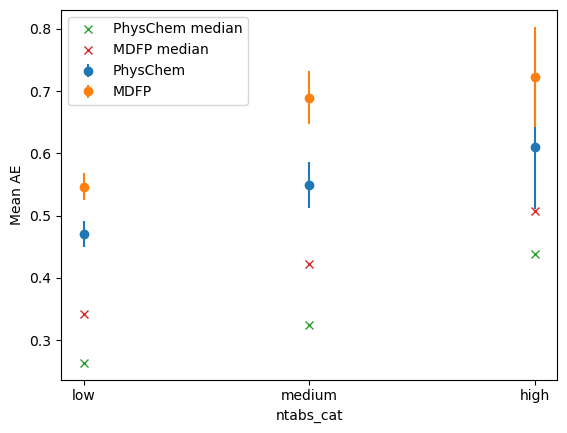

ntabs_cat
low       0.263545
medium    0.323969
high      0.439088
Name: AE_physchem, dtype: float64


In [348]:
#ntabs_cat: <= 50 ntabs = 'low', 50-99999 ntabs = 'medium', > 99999 ntabs = 'high'
df_results['ntabs_cat'] = pd.cut(df_results['ntabs'], bins=[0, 50, 99999, 100000000], labels=['low', 'medium', 'high'])
df_results['ntabs_cat'].value_counts()
#barplot: mean and 95CI of AE PhysChem and AE MDFP per ntabs_cat
import matplotlib.pyplot as plt
import seaborn as sns

#calculate mean and 95CI of AE PhysChem and AE MDFP per ntabs_cat
physchem_means = df_results.groupby('ntabs_cat')['AE_physchem'].mean()
physchem_ci = df_results.groupby('ntabs_cat')['AE_physchem'].std() * 1.96 / df_results.groupby('ntabs_cat')['AE_physchem'].count()**0.5
mdfp_means = df_results.groupby('ntabs_cat')['AE_MDFP'].mean()
mdfp_ci = df_results.groupby('ntabs_cat')['AE_MDFP'].std() * 1.96 / df_results.groupby('ntabs_cat')['AE_MDFP'].count()**0.5
physchem_medians = df_results.groupby('ntabs_cat')['AE_physchem'].median()
mdfp_medians = df_results.groupby('ntabs_cat')['AE_MDFP'].median()
#plot
plt.figure()
x = np.arange(len(physchem_means))
plt.errorbar(x, physchem_means, yerr=physchem_ci, label='PhysChem',linestyle='',marker = 'o')
plt.errorbar(x, mdfp_means, yerr=mdfp_ci, label='MDFP',linestyle='',marker = 'o')
#add medians
plt.plot(x, physchem_medians, label='PhysChem median',linestyle='',marker = 'x')
plt.plot(x, mdfp_medians, label='MDFP median',linestyle='',marker = 'x')
plt.xticks(x, ['low', 'medium', 'high'])
plt.xlabel('ntabs_cat')
plt.ylabel('Mean AE')
plt.legend()
plt.show()
#print medians for physchem
print(physchem_medians)


In [350]:
#also plot number of datapoints for each
df_results['ntabs_cat'].value_counts()

ntabs_cat
low       3338
medium    1345
high       272
Name: count, dtype: int64

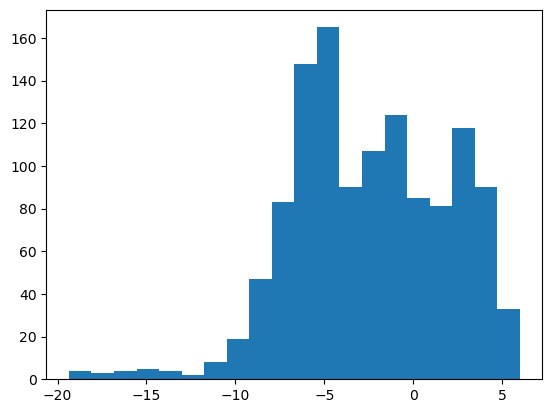

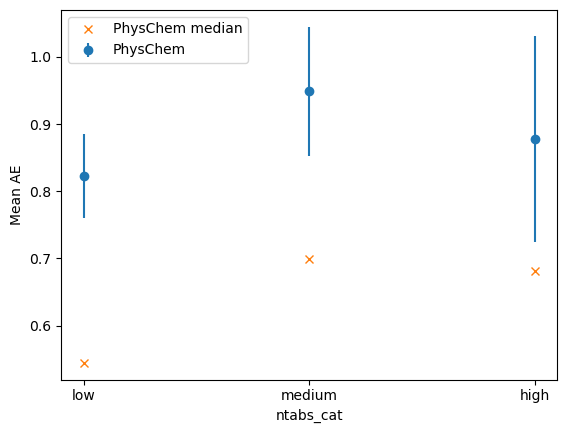

ntabs_cat
low       0.544611
medium    0.699049
high      0.681705
Name: AE_Physchem, dtype: float64
ntabs_cat
low       748
medium    356
high      116
Name: count, dtype: int64


In [362]:
plt.hist(df_downsampled_physchem['vp_log10_pa'].values, bins=20)
df_results = df_downsampled_physchem.copy()
df_results['ntabs_cat'] = pd.cut(df_results['ntabs'], bins=[0, 50, 99999, 100000000], labels=['low', 'medium', 'high'])
df_results['ntabs_cat'].value_counts()
#barplot: mean and 95CI of AE PhysChem and AE MDFP per ntabs_cat
import matplotlib.pyplot as plt
import seaborn as sns

#calculate mean and 95CI of AE PhysChem and AE MDFP per ntabs_cat
physchem_means = df_results.groupby('ntabs_cat')['AE_Physchem'].mean()
physchem_ci = df_results.groupby('ntabs_cat')['AE_Physchem'].std() * 1.96 / df_results.groupby('ntabs_cat')['AE_Physchem'].count()**0.5
physchem_medians = df_results.groupby('ntabs_cat')['AE_Physchem'].median()

plt.figure()
x = np.arange(len(physchem_means))
plt.errorbar(x, physchem_means, yerr=physchem_ci, label='PhysChem',linestyle='',marker = 'o')
#add medians
plt.plot(x, physchem_medians, label='PhysChem median',linestyle='',marker = 'x')
plt.xticks(x, ['low', 'medium', 'high'])
plt.xlabel('ntabs_cat')
plt.ylabel('Mean AE')
plt.legend(loc = 'upper left')
plt.show()
#print medians for physchem
print(physchem_medians)
print(df_results['ntabs_cat'].value_counts())


In [356]:
df_results

,Pred_Physchem,vp_log10_pa,molregno,ntabs,log10ntabs,AE_Physchem,ntabs_cat
0,-1.750505,-2.970898,617,42,1.623249,1.220393,low
1,-10.858046,-10.360000,15834,1000000,6.000000,0.498046,high
2,-2.413835,-2.214000,3006,2,0.301030,0.199835,low
3,3.627435,3.359201,2631,1,0.000000,0.268234,low
4,-4.537341,-2.665599,16505,810,2.908485,1.871742,medium
...,...,...,...,...,...,...,...
1215,-0.917870,-0.435799,3061,2,0.301030,0.482071,low
1216,0.217887,0.602203,1046,162,2.209515,0.384316,medium
1217,-5.048872,-3.522898,592,38016,4.579966,1.525974,medium
1218,2.118545,0.843402,2868,36,1.556303,1.275143,low
